# A Minimal example of NISQ simulation with QuTiP

In [1]:
import copy
import numpy as np
pi = np.pi
from qutip.qip.models.circuitprocessor import CircuitProcessor
from qutip.qip.models.circuitnoise import WhiteNoise
from qutip.operators import sigmaz, sigmay, sigmax
from qutip.qip.gates import rx, ry, rz
from qutip.states import basis
from qutip.metrics import fidelity

The simulation of quantum information processing is based on the QuTiP Lindbladian equation solver. As it simulates the dynamics of the qubits under the driving Hamiltonian, its closer to the physical realization than the common approach. The simulator, under the name of `CircuitPorcessor`, simulates general quantum devices for noisy quantum computing. This example contains the most essential part of the hardware simulator, i.e. the noisy evolution under given control pulse. Gate decomposition under specific hardware realization can be found in the subclasses.

## The 3 main ingredients for unitary evolution

The simulation of a unitary evolution with `CircuitPorcessor` needs at least 3 ingredients: the control Hamiltonian $\cal H_i$, the pulse intensity $c_i$ and the time $t$. The evolution is given by $U(t)=\exp(-i \sum_i c_i{\cal H}_i t)$.

The `CircuitPorcessor`, as a simulator of a quantum device, is determined by a list of Hamiltonians, i.e. the control pulse driving the evolution. In this minial example, we define a single-qubit quantum device with $\sigma_z$ and $\sigma_y$ pulse.

In [2]:
processor = CircuitProcessor(N=1)
processor.add_ctrl(sigmaz(), targets=0)
processor.add_ctrl(sigmay(), targets=0)
processor.ctrls

[Quantum object: dims = [[2], [2]], shape = (2, 2), type = oper, isherm = True
 Qobj data =
 [[ 1.  0.]
  [ 0. -1.]],
 Quantum object: dims = [[2], [2]], shape = (2, 2), type = oper, isherm = True
 Qobj data =
 [[0.+0.j 0.-1.j]
  [0.+1.j 0.+0.j]]]

The pulse intensity and time for each pulse are saved in the attributes `coeff`, a 2-d NumPy array, and `tlist`, a 1-d NumPy array. `tlist` specifies the start and the end of each pulse, and thus is one element longer the `coeff`. (This is different from the usual requrement in QuTiP solver where `tlist` and `coeff` needs to have the same length.) The definition below means that we turn on $\sigma_y$ pulse for $t=\pi$, with intensity 0.5

In [3]:
processor.coeff = np.array([[ 0. ],
                            [ 0.5]])
processor.tlist = np.array([0., pi])

This pulse is a $\pi$ pulse that flip the qubit from $\left |0 \right\rangle$ to $\left |1 \right\rangle$, equvilent to a rotation around y-axis of angle $\pi$:

$$R_y(\theta) = \begin{pmatrix} cos(\theta/2) & -sin(\theta/2) \\ sin(\theta/2) & cos(\theta/2) \end{pmatrix}$$

We can run the simulation to see the result of the evolution starting from $\left |0 \right\rangle$:

In [4]:
basis0 = basis(2, 0)
result = processor.run_state(rho0=basis0)
result.states[-1]

Quantum object: dims = [[2], [1]], shape = (2, 1), type = ket
Qobj data =
[[-4.71578886e-07]
 [ 1.00000000e+00]]

As arbitrary single-qubit gate can be decomposed into $R_z(\theta_1) \cdot R_y(\theta_2) \cdot R_z(\theta_3)$, it is enough to use three pulses. For demonstration purpose we choose a $\theta_1=\theta_2=\theta_3=\pi/2$

In [5]:
processor.coeff = np.array([[ 0.5, 0.,  0.5],
                            [ 0. , 0.5, 0. ]])
processor.tlist = np.array([0., pi/2., 2*pi/2, 3*pi/2])

In [6]:
result = processor.run_state(rho0=basis(2, 0))
result.states[-1].tidyup(1.0e-5) 

Quantum object: dims = [[2], [1]], shape = (2, 1), type = ket
Qobj data =
[[0.       -0.70710926j]
 [0.7071043+0.j        ]]

## Noisy evolution

`Circuitprocessor` as a circuit simulator, is different from the common simulator of quantum information processing, as it simulates the dynamics of the qubits under the driving Hamiltonian. Therefore the definition of noise is also more physical than the common approach.

### Decoherence

In `Circuitprocessor`, decoherence noise is simulated by adding collapse operator into the Lindbladian equation. This approach is equvilent to apply random bit flip and phase flip error after applying the quantum gate, but more phyiscal, and is valid even if the the gate time is not much shorter than the decay time. For easy use, one can simply specify the $T_1$ and $T_2$ time for the device or for each qubits.

In [7]:
processor_dec = copy.deepcopy(processor)
processor_dec.T1=50
processor_dec.T2=20

We compare the result of the evolution with and without noise. In the second case, the result is nolonger a pure state but a mixed density operator and the fidelity decreases accordingly.

In [8]:
result = processor.run_state(rho0=basis(2, 1))
result.states[-1].tidyup(1.0e-5) 

Quantum object: dims = [[2], [1]], shape = (2, 1), type = ket
Qobj data =
[[-0.7071043+0.j        ]
 [ 0.       +0.70710926j]]

In [9]:
result_dec = processor_dec.run_state(rho0=basis(2, 1))
result_dec.states[-1].tidyup(1.0e-5)

Quantum object: dims = [[2], [2]], shape = (2, 2), type = oper, isherm = True
Qobj data =
[[0.51856536+0.j         0.        +0.40156243j]
 [0.        -0.40156243j 0.48143464+0.j        ]]

In [10]:
fidelity(result.states[-1], result_dec.states[-1])

0.949506354426215

### White noise in pulse intensity

Despite the decoherence, `CircuitProcessor` can also simulate pulse noise. For more general types of noise, one can define a noise object and add it to the processor. An example of predefined noise is the white noise, where random value is added to the pulse with time interval `dt`. 

In [11]:
processor_white = copy.deepcopy(processor)
processor_white.add_noise(WhiteNoise(mean=0.05, std=0.02, dt=0.1))  # gausian white noise

We again compare the result of the evolution with and without noise.

In [12]:
result = processor.run_state(rho0=basis(2, 1))
result.states[-1].tidyup(1.0e-5) 

Quantum object: dims = [[2], [1]], shape = (2, 1), type = ket
Qobj data =
[[-0.7071043+0.j        ]
 [ 0.       +0.70710926j]]

In [13]:
result_white = processor_white.run_state(rho0=basis(2, 1))
result_white.states[-1].tidyup(1.0e-5)

Quantum object: dims = [[2], [1]], shape = (2, 1), type = ket
Qobj data =
[[-0.80643916+0.00438211j]
 [-0.23605538+0.54213885j]]

In [14]:
fidelity(result.states[-1], result_white.states[-1])

0.9675569859629147

The two figures below shows the control pulse with and without noise.

(<Figure size 864x432 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x2013b162cf8>)

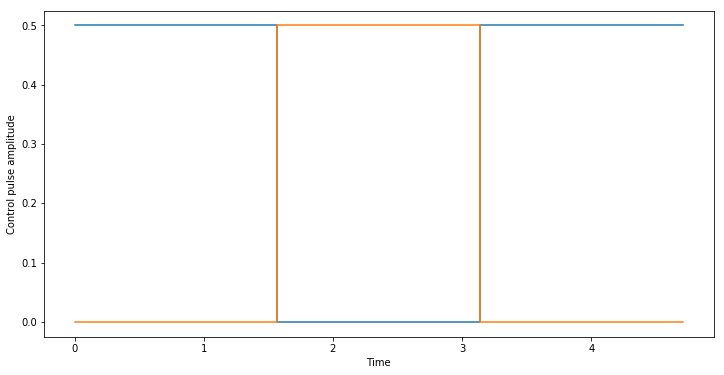

In [15]:
processor_white.plot_pulses(noisy=False)

(<Figure size 864x432 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x2013b37f470>)

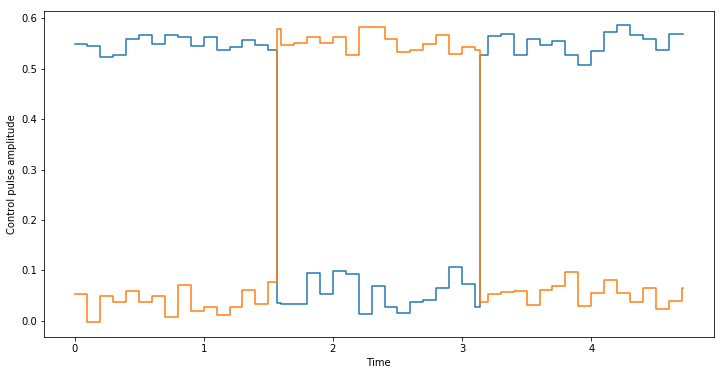

In [16]:
processor_white.plot_pulses(noisy=True)